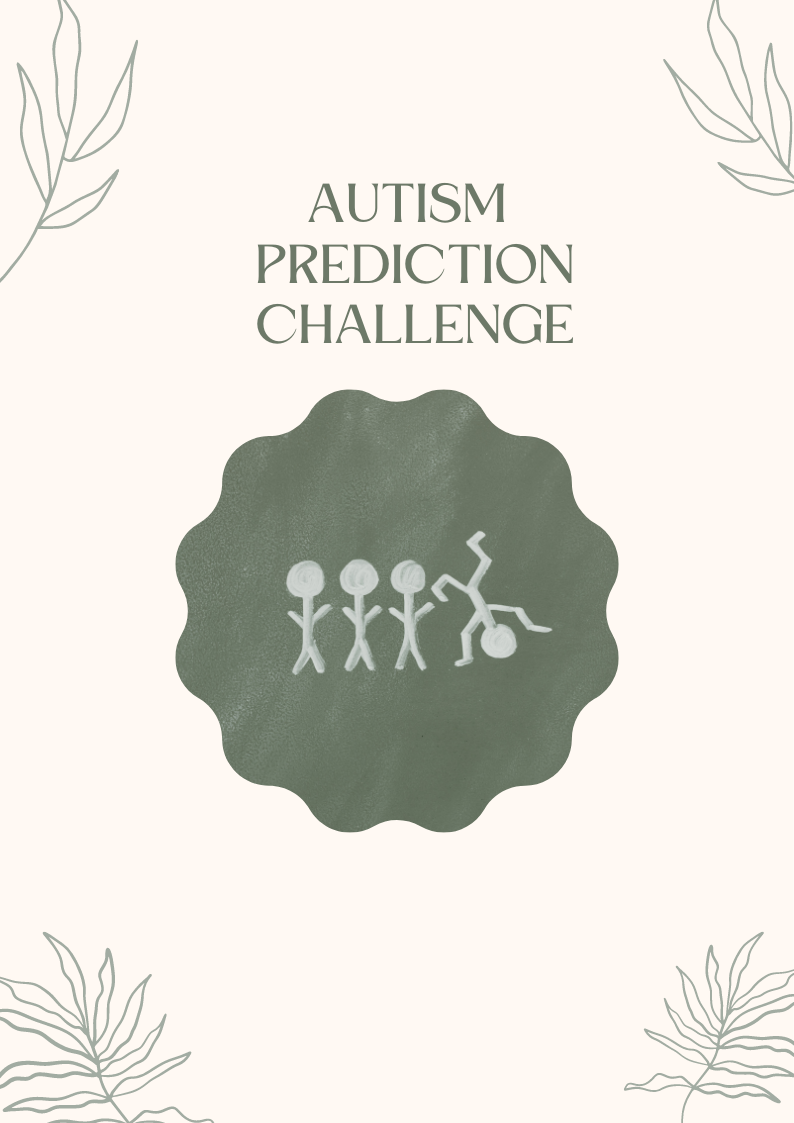

# <p style="text-align:center;font-size:150%;font-family:Roboto;background-color:#a04070;border-radius:50px;font-weight:bold;margin-bottom:0">Autism Prediction Challenge</p>

<p style="font-family:Roboto;font-size:140%;color:#a04070;">In this Notebook, I had implemented the model to predict based on certain Indexes and some historical and geographical information whether the person have Autism or not. I would like to thank <a href='https://www.kaggle.com/sanjaylalwani', target='_blank'>Sanjay Lalwani</a> for this awesome <a href='https://www.kaggle.com/code/sanjaylalwani/autism-diagnosis-with-flaml/notebook', target='_blank'>notebook</a> I had learnt and applied some cool things I learned from this.<p> 

<!-- <a id='top'></a> -->
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#a04070;font-family:Roboto;font-size:160%;text-align:center;border-radius:50px;">TABLE OF CONTENTS</p>   
    
* [1. Importing Libraries](#1)
    
* [2. Exploratory Data Analysis](#2)
    
* [3. Baseline Solution](#3)
    
* [4. Feature Engineering and Data Preprocessing](#4)
    
* [5. Predictions](#5) 
    
* [6. Ending Note and Top Submissions](#6) 


<a id="1"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">IMPORTING LIBRARIES</p>

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Exploratory Data Analysis</p>
<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">After seperating the columns based on the format in which they contain data I had performed EDA which shows their relation with the target column.</p>

In [44]:
df = pd.read_csv('../input/autismdiagnosis/Autism_Prediction/train.csv')
print(df.shape)
df.head()

(800, 22)


,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


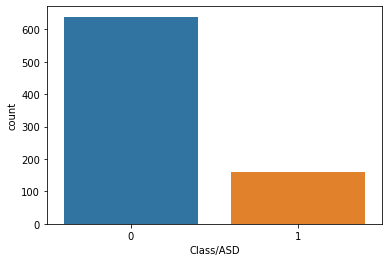

In [45]:
sb.countplot(df['Class/ASD'])
plt.show()

In [46]:
df['Class/ASD'].value_counts()

0    639
1    161
Name: Class/ASD, dtype: int64

<ul style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0"><li>This implies that we have a highly skewed data set with more examples for the negative class. Only 20% of the data is given for the positive class.</li><li>

So, before training of the model we will normalize the data. Else our model will have a hard time generalizing for the positive example which is the main motive.</li></ul>

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Although this is showing that there are no null values but this is not true because instead of null value a question mark has been given. In my opinion presence of such question marks is the result of resistance of the people from which this data has been collected to give such a sensitive information.</p>

In [48]:
df['ethnicity'].value_counts()

White-European     257
?                  203
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Others              29
Latino              17
Hispanic             9
Turkish              5
others               3
Name: ethnicity, dtype: int64

In [49]:
df['relation'].value_counts()

Self                        709
?                            40
Parent                       29
Relative                     18
Others                        2
Health care professional      2
Name: relation, dtype: int64

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Here 'others', 'Others' and '?' these three should be in the same category so, data cleaning is also required.</p>

In [50]:
df = df.replace({'?':'Others', 'others':'Others'})

In [51]:
ints = []
objects = []
floats = []

for col in df.columns:
  if df[col].dtype == int:
    ints.append(col)
  elif df[col].dtype == object:
    objects.append(col)
  else:
    floats.append(col)

In [52]:
print(ints)
print(objects)
print(floats)

['ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'Class/ASD']
['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before', 'age_desc', 'relation']
['age', 'result']


In [53]:
ints.remove('ID')
ints.remove('Class/ASD')

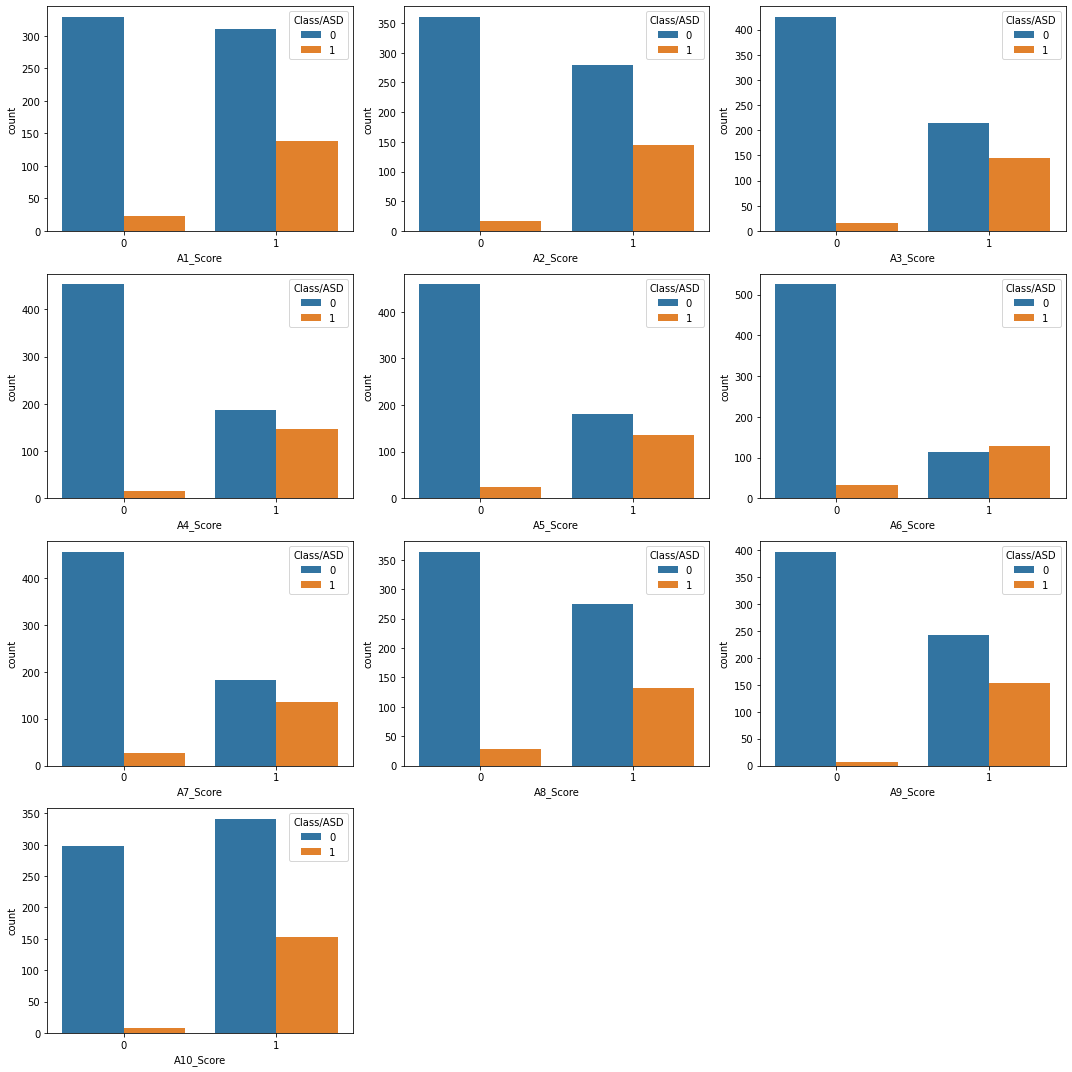

In [54]:
plt.subplots(figsize=(15,15))

for i, col in enumerate(ints):
  plt.subplot(4,3,i+1)
  sb.countplot(df[col], hue=df['Class/ASD'])
plt.tight_layout()
plt.show()

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">From these plots we can conclude that if the score of some indicator is 0 then the chances of that person not having autism is quite high except in the case of <code>A10_Score</code>.</p>

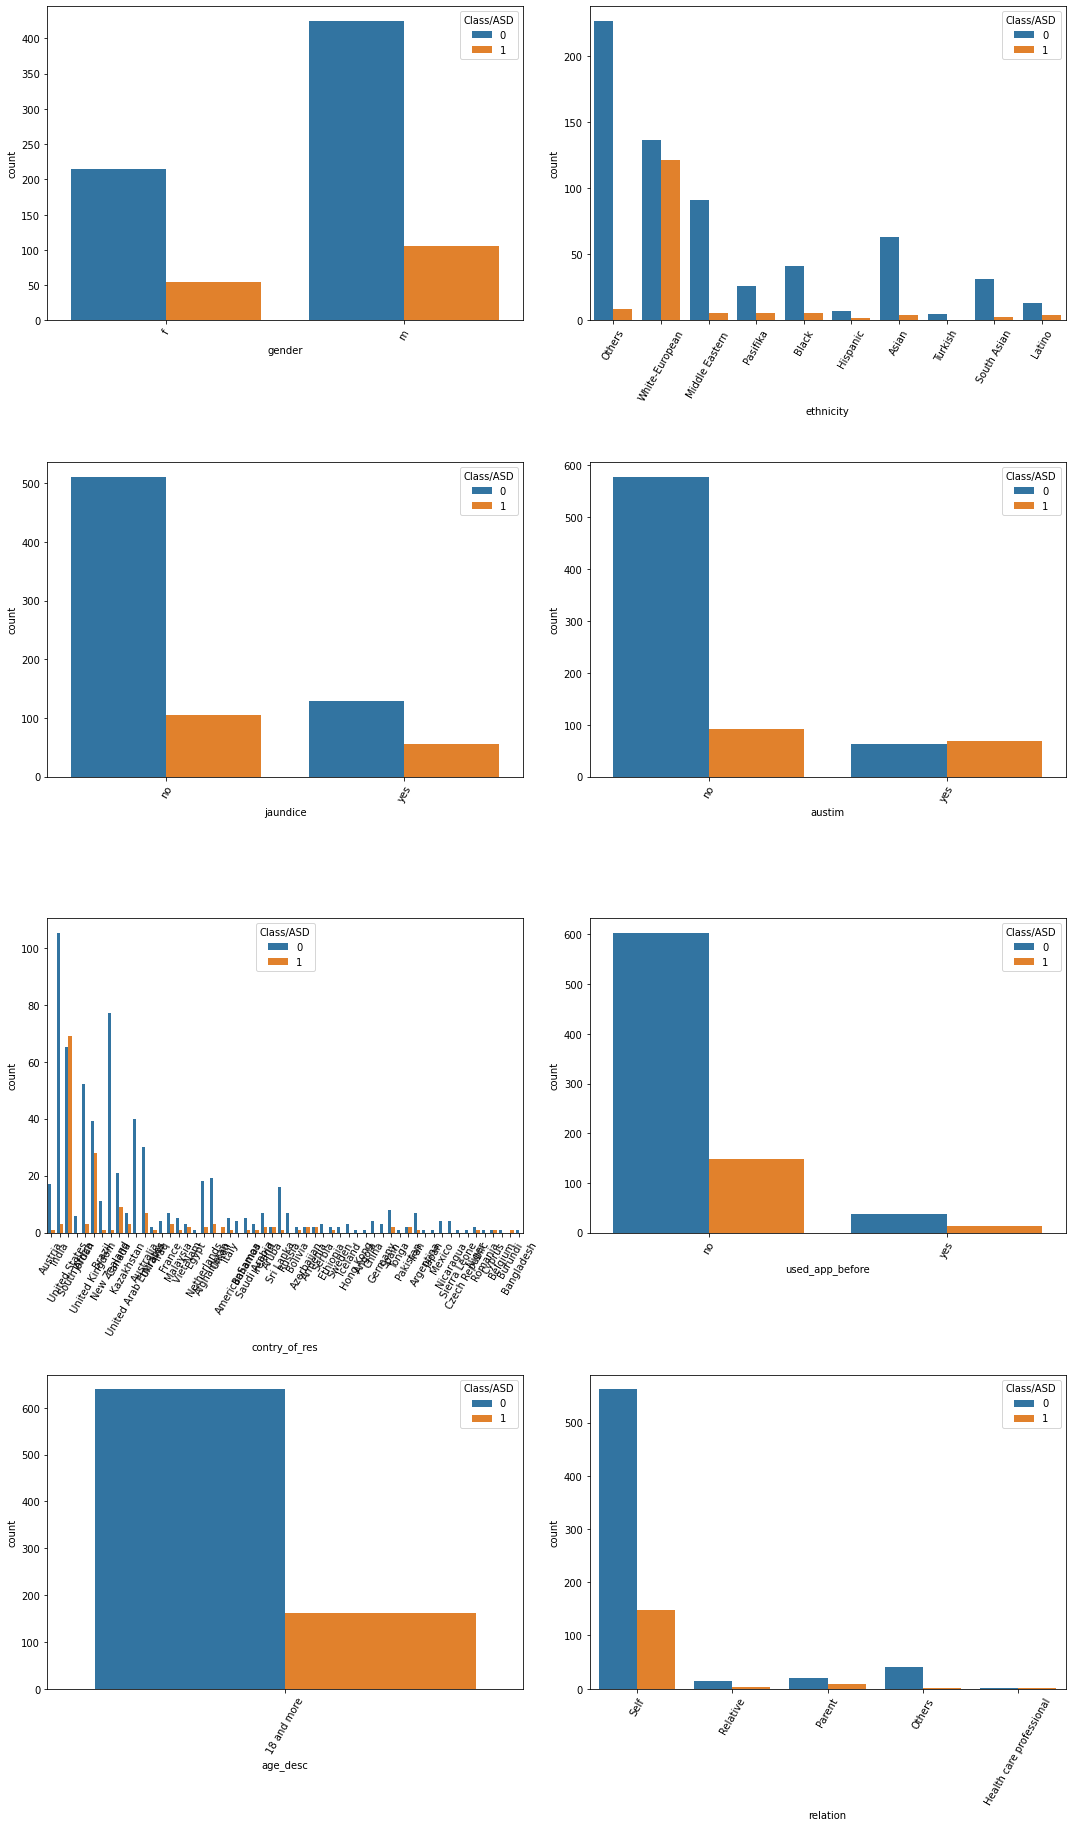

In [55]:
plt.subplots(figsize=(15,30))

for i, col in enumerate(objects):
  plt.subplot(5,2,i+1)
  sb.countplot(df[col], hue=df['Class/ASD'])
  plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

<ul style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">
    <li><code>Age_desc</code> is same for all the data points.</li>
    <li>This <code>used_app_before</code> feature is doesn't seems to be useful or it will be the source of data leakage.</li>
    <li>Here it seems like chances of a male having autism is higher than female but that is not true because we don't have equal number of examples of male and female.</li>
</ul>

In [56]:
df['jaundice'].value_counts()

no     615
yes    185
Name: jaundice, dtype: int64

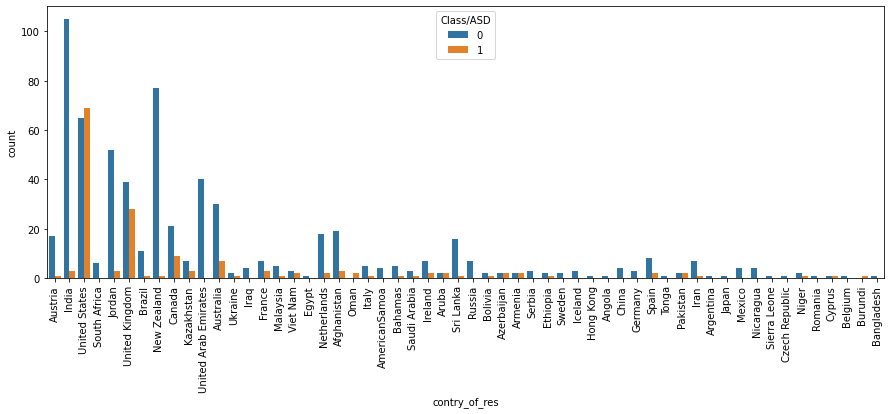

In [57]:
plt.figure(figsize=(15,5))
sb.countplot(data=df, x='contry_of_res', hue='Class/ASD')
plt.xticks(rotation=90)
plt.show()

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">At some places approximately 50% of the data available for that country have autism and at some places this is quite low. This implies that the geography of a person also gives an idea of having autism.</p>

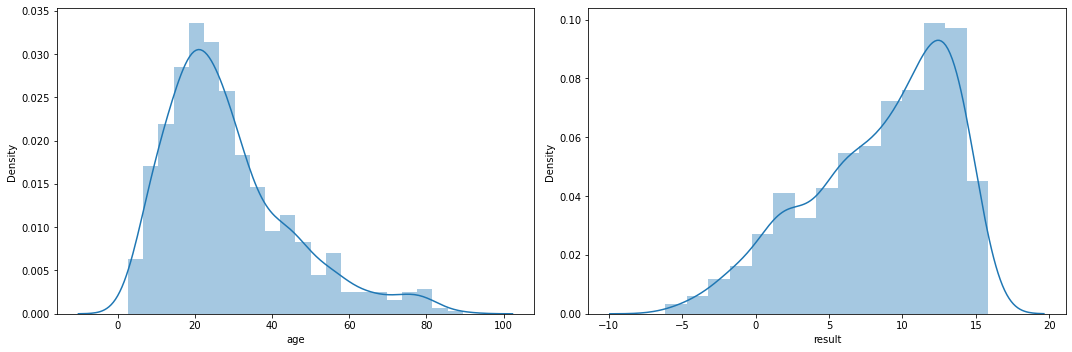

In [58]:
plt.subplots(figsize=(15,5))

for i, col in enumerate(floats):
  plt.subplot(1,2,i+1)
  sb.distplot(df[col])
plt.tight_layout()
plt.show()

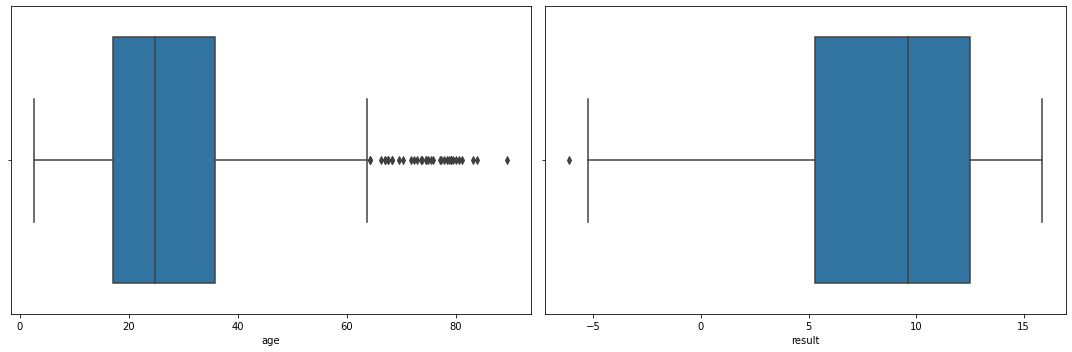

In [59]:
plt.subplots(figsize=(15,5))

for i, col in enumerate(floats):
  plt.subplot(1,2,i+1)
  sb.boxplot(df[col])
plt.tight_layout()
plt.show()

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Ah! some outlier in the <code>result</code> column. Let's remove that as it doesn't seems like too much loss to the information.</p>

In [60]:
df = df[df['result']>-5]
df.shape

(798, 22)

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">So, here we lost only two data points.</p>

In [61]:
df['age'] = df['age'].apply(lambda x: np.log(x))

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">To handle the skewness of the data performing logarithmic transformation seems like a good idea.</p>

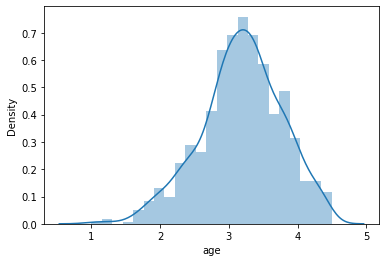

In [62]:
sb.distplot(df['age'])
plt.show()

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">We will normalize this age data to convert into a normal distribution from left skewed distribution of values.</p>

<a id="3"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Baseline Solution</p>
<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">It is always suggested to build a quick and easy implementation of a model on your data so, that can be your baseline to try out different feature engineering techniques and hyperparameter tuning to judge which experiments are helping and which doesn't.
</p>

In [63]:
df = pd.read_csv('../input/autismdiagnosis/Autism_Prediction/train.csv')
df = df.replace({'yes':1, 'no':0, '?':'Others', 'others':'Others'})

# Applying log transformations to remove the skewness of the data.
df['age'] = df['age'].apply(lambda x: np.log(x))

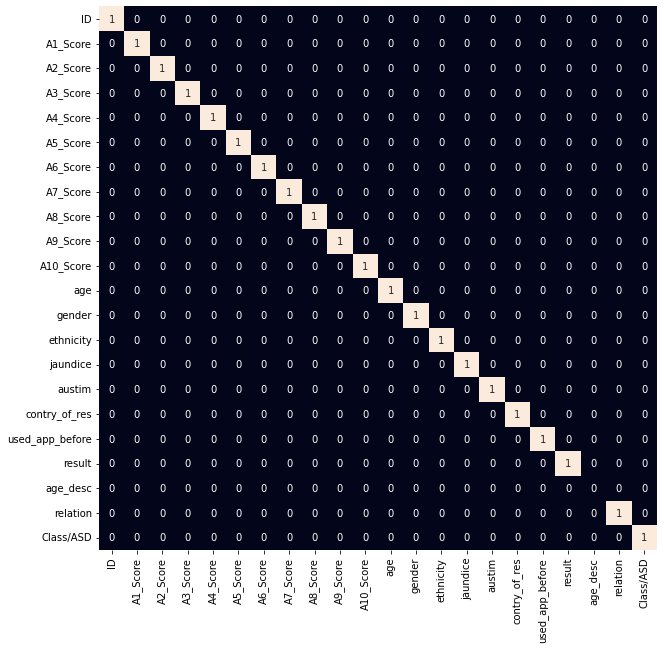

In [64]:
def encode_labels(data):
    for col in data.columns:
      if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
    
    return data

df = encode_labels(df)

plt.figure(figsize=(10,10))
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.show()

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">No highly correlated features so, we are good to go.</p>

In [65]:
removal = ['ID', 'age_desc', 'used_app_before']
features = df.drop(removal + ['Class/ASD'], axis=1)
target = df['Class/ASD']

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Now as it is the time to train a ML model to see how it performs we will balance the number of positive and negative examples in the training data.</p>

In [66]:
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size = 0.2, random_state=10)

# As the data was highly imbalanced we will balance it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',random_state=0)
X, Y = ros.fit_resample(X_train,Y_train)

# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)

In [67]:
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf')]

for model in models:
  model.fit(X, Y)

  print(f'{model} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(Y, model.predict(X)))
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, model.predict(X_val)))
  print()

LogisticRegression() : 
Training Accuracy :  0.8540856031128404
Validation Accuracy :  0.8285714285714286

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.7114285714285714

SVC() : 
Training Accuracy :  0.9328793774319065
Validation Accuracy :  0.8



<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Logistic regression has a low difference between the training and the validation data rest are showing overfitting. So, till now Logistic regression's 82% performance will be my checkpoint to build upon this.</p>

<a id="4"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Feature Engineering</p>
<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">In this section we will add some features which can be useful for the model's performance and check their ability to improve model's performance by comparing the accuracy with the baseline score.</p>

In [68]:
df = pd.read_csv('../input/autismdiagnosis/Autism_Prediction/train.csv')
df_test = pd.read_csv('../input/autismdiagnosis/Autism_Prediction/test.csv')

df = df.replace({'yes':1, 'no':0, '?':'Others', 'others':'Others'})
df_test = df_test.replace({'yes':1, 'no':0, '?':'Others', 'others':'Others'})

In [69]:
def convertAge(age):
    if age < 4:
        return 'Toddler'
    elif age < 12:
        return 'Kid'
    elif age < 18:
        return 'Teenager'
    elif age < 40:
        return 'Young'
    else:
        return 'Senior'

df['ageGroup'] = df['age'].apply(convertAge)
df_test['ageGroup'] = df_test['age'].apply(convertAge)

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Creating different groups of individuals as after logarithmic transformation this will retain that information.</p>

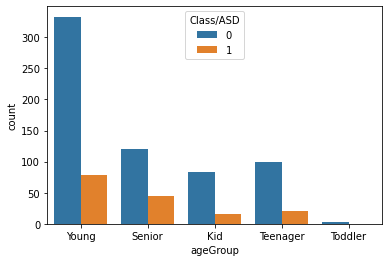

In [70]:
sb.countplot(x=df['ageGroup'], hue=df['Class/ASD'])
plt.show()

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Young and Toddler group of people have lower chances of having Autism.</p>

In [71]:
# Applying the log transformation as we did in the training data.
df['age'] = df['age'].apply(lambda x: np.log(x))
df_test['age'] = df_test['age'].apply(lambda x: np.log(x))

In [72]:
def add_feature(data):
  data['sum_score'] = 0
  for col in data.loc[:,'A1_Score':'A10_Score'].columns:
    data['sum_score'] += data[col]

  data['ind'] = data['austim'] + data['used_app_before'] + data['jaundice']

  return data


df = add_feature(df)
df_test = add_feature(df_test)

<ul style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">
    <li><code>sum_score</code>: Sum of the 10 spectrum quotient from <code>A1</code> to <code>A10</code>
    </li>
    <li><code>ind</code>: As we will remove the used_app_before combining it with some useful information may be this can help.
    </li>
</ul>

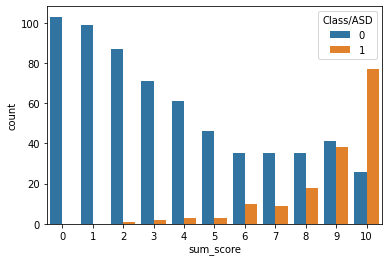

In [73]:
sb.countplot(x=df['sum_score'], hue=df['Class/ASD'])
plt.show()

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Higher the sum score higher the chances of having autism.</p>

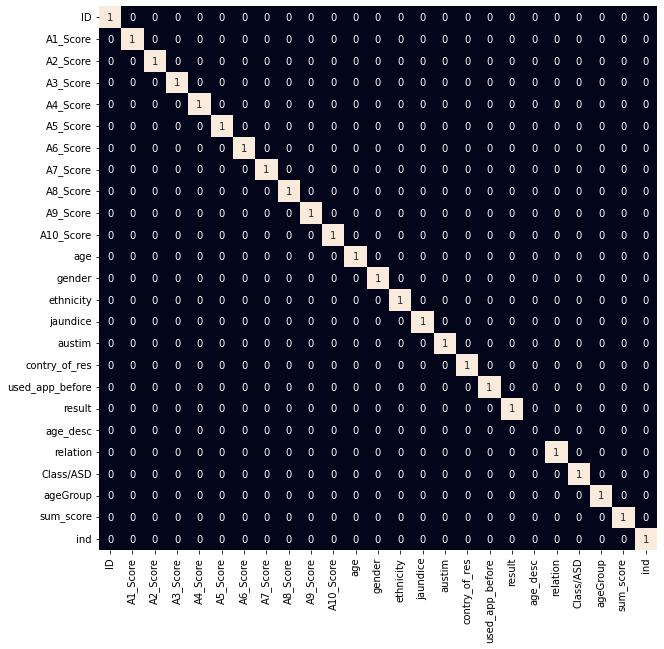

In [74]:
def encode_labels(features, test):
    for col in features.columns:
      if features[col].dtype == 'object':
        le = LabelEncoder()
        set1 = set((features[col].values))
        set2 = set(list(test[col].values))

        le.fit(list(set1.union(set2)))
        features[col] = le.transform(features[col])
        test[col] = le.transform(test[col])
    
    return features, test

df, df_test = encode_labels(df, df_test)

plt.figure(figsize=(10,10))
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.show()

In [75]:
removal = ['ID', 'age_desc', 'relation', 'used_app_before']
features = df.drop(removal + ['Class/ASD'], axis=1)
target = df['Class/ASD']

test = df_test.drop(removal, axis=1)

In [76]:
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size = 0.2, random_state=10)

ros = RandomOverSampler(sampling_strategy='minority',random_state=0)
X, Y = ros.fit_resample(X_train,Y_train)

# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)
test = scaler.transform(test)

In [77]:
print(X.shape, Y.shape)

(1028, 20) (1028,)


In [78]:
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf', probability=True)]

for model in models:
  model.fit(X, Y)

  print(f'{model} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(Y, model.predict(X)))
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, model.predict(X_val)))
  print()

LogisticRegression() : 
Training Accuracy :  0.8560311284046692
Validation Accuracy :  0.8285714285714286

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.744

SVC(probability=True) : 
Training Accuracy :  0.9299610894941635
Validation Accuracy :  0.8142857142857144



<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">No remarkable change in the performance of the model by addition of these features so, the features we had introduces has no use they are just providing a better insights of the data.</p>

In [79]:
model = LogisticRegression()
model.fit(X, Y)
pred_log = model.predict(test)

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">SVC and XGBClassifier is facing high overfitting so, the model with the best performance is LogisticRegression.
</p>

In [80]:
ss = pd.read_csv('../input/autismdiagnosis/Autism_Prediction/sample_submission.csv')
ss['Class/ASD'] = pred_log

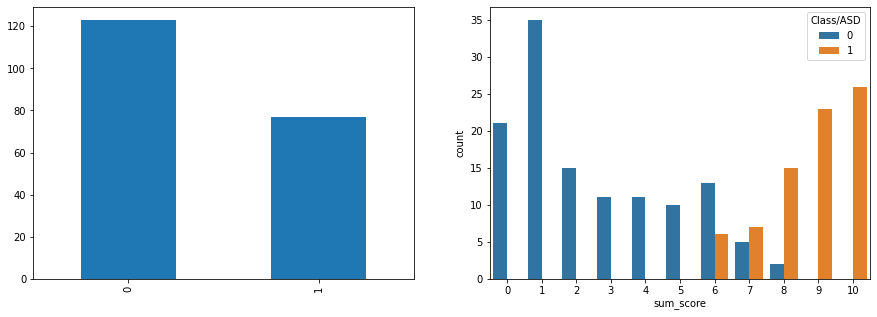

In [81]:
plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
ss['Class/ASD'].value_counts().plot.bar()
plt.subplot(1,2,2)
sb.countplot(x=df_test['sum_score'], hue=ss['Class/ASD'])
plt.show()

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">As you can see in this notebook of mine how sum score is related with the target class. There will be some what similar trend in the test data as well. So, by visualizing this we can get a feel of correctness of this.</p>

In [ ]:
ss.to_csv('Submission.csv', index=False)
ss.head()

<a id="5"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">End Note and Top Submissions</p>
<ul style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">
    <li>Public kernels with around 85% accuracy on test data have submitted their results in terms of probability but we are supposed to do so that in the 0 and 1 format only.</li>
    <li>You can read in this awesome <a href='https://www.kaggle.com/competitions/autismdiagnosis/discussion/324427', target='_blank'> explanation</a> by <a href='https://www.kaggle.com/francuzovd', target='_blank'>Dmitriy Frantsuzov</a> that why the ROC AUC score on binary predictions is always less than the probability predictions.
    </li>
</ul>